       2019-01-01 00:30:00  66.24000000000001
0      2019-01-01 01:00:00              66.24
1      2019-01-01 01:30:00              66.36
2      2019-01-01 02:00:00              66.00
3      2019-01-01 02:30:00              66.00
4      2019-01-01 03:00:00              66.00
...                    ...                ...
36570  2021-01-31 22:00:00              69.36
36571  2021-01-31 22:30:00              70.56
36572  2021-01-31 23:00:00              69.60
36573  2021-01-31 23:30:00              70.08
36574  2021-02-01 00:00:00              69.48

[36575 rows x 2 columns]
0        66.24
1        66.36
2        66.00
3        66.00
4        66.00
         ...  
36570    69.36
36571    70.56
36572    69.60
36573    70.08
36574    69.48
Name: 66.24000000000001, Length: 36575, dtype: float64
0.03961513281945456


<AxesSubplot:>

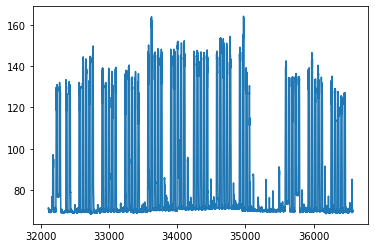

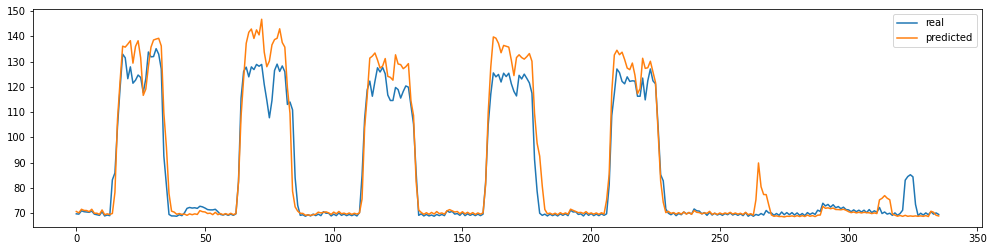

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("sever_data.csv")
print(df)
plt.plot([i for i in range(len(df))[-48*31*3:]], df.iloc[:, 1][-48*31*3:])
data = df.iloc[:, 1]
print(data)

# параметры 
s = 7 * 48 # период сезонности
idx_start = -48*32
d = 48*7
idx_end = -d
alpha = np.array([0.1, 0.6]) # параметры сглаживания (от 0 до 1)

def error(predicted, real):
    return np.mean(np.abs(real - predicted)/real)


def MSAE(real, pred):
    return np.power(real-pred, 2).mean()


def MAE(real, pred):
    return (real-pred).mean()
def lin_trend_with_add_season(y, alpha, d):  # slide 14
    n = y.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] - theta[t - s]) + (1 - alpha[0]) * (a[t - 1] + b[t - 1])
        b[t] = alpha[1] * (a[t] - a[t - 1])+(1 - alpha[1]) * b[t - 1]
        theta[t] = alpha[2] * (y[t] - a[t]) + (1 - alpha[2]) * theta[t - s]
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = (a[t - d]+(b[t - d] * d)) + theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def lin_trend_with_add_season_fit(series, d=48):
    min_error = 4
    t_a = 0
    t_b = 0
    t_g = 0
    for alpha in range(10):
        for beta in range(10):
            for gamma in range(10):
                train = series[:-d]
                test = series[-d:]
                predicted_next_values = lin_trend_with_add_season(train, np.array([alpha/10, beta/10, gamma/10]), len(test))
                e = error(predicted_next_values, np.array(test))
                if e < min_error:
                    min_error = e
                    t_a = alpha/10
                    t_b = beta/10
                    t_g = gamma/10
    return np.array([t_a, t_b, t_g])


alpha = lin_trend_with_add_season_fit(data[idx_start:idx_end].values, d)
predicted_next_values = lin_trend_with_add_season(data[idx_start:idx_end].values, alpha, d)
real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": predicted_next_values
    }
)
print(error(predicted_next_values, real_next_values))
results_predict.plot(figsize=(17, 4))

In [ ]:
def whinters(y,  alpha, d): # d - горизонт прогнозирования  slide 15
    n = y.shape[0]
    
    a = np.zeros(n)
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * a[t - 1]
        theta[t] = alpha[1] * (y[t] / a[t]) + (1 - alpha[1]) * theta[t - s]
    
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = a[t - d] * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def whinters_fit(series, l=48):
    min_error = 4
    t_a = 0
    t_b = 0
    for alpha in range(10):
        for beta in range(10):
#             for i in range(1, n+1):
#                 train = series[:i*(len(series)//(n+1))]
#                 test = series[i*(len(series)//(n+1)):(i+1)*(len(series)//(n+1))]
#                 predicted_next_values = predict(train, np.array([alpha/10, beta/10]), len(test))
#                 errors.append(error(predicted_next_values, test))
#             print(np.array(errors))
            train = series[:-l]
            test = series[-l:]
            predicted_next_values = whinters(train, np.array([alpha/10, beta/10]), len(test))
            e = error(predicted_next_values, np.array(test))
            if e < min_error:
                min_error = e
                t_a = alpha/10
                t_b = beta/10
    return np.array([t_a, t_b])
alpha = whinters_fit(data[idx_start:idx_end].values, d)
predicted_next_values = whinters(data[idx_start:idx_end].values, alpha, d)
real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": predicted_next_values
    }
)
print(error(predicted_next_values, real_next_values))
results_predict.plot(figsize=(17, 4))

In [ ]:
def trigg_lych(y, alpha, d, gamma=0.05):
    n = y.shape[0]
    a = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * a[t - 1]
        theta[t] = alpha[1] * (y[t] / a[t]) + (1 - alpha[1]) * theta[t - s]
        e[t] = gamma*(a[t] * theta[t + (d % s) - s]-y[t])+(1-gamma)*(e[t-1])
        e_abs[t] = gamma*(a[t] * theta[t + (d % s) - s]-y[t])+(1-gamma)*(e_abs[t-1])
        if not np.isclose(e_abs[t], 0):
            K = abs(e[t]/e_abs[t])
            alpha[0] = K
        
        
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = a[t - d] * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

predicted_next_values = trigg_lych(data[idx_start:idx_end].values, alpha, d, gamma=0.01)
real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": predicted_next_values
    }
)
print(error(predicted_next_values, real_next_values))
results_predict.plot(figsize=(17, 4))

0.039652585470258905


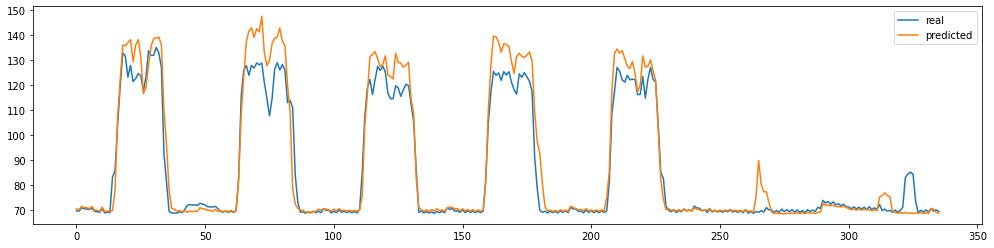

In [18]:
def whinters_with_linear_trend(y, alpha, d):  # slide 16
    n = y.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    e = np.zeros(n+d)
    e_abs = np.zeros(n+d)
    K = 1
    theta = np.zeros(n)
    for t in range(s):
        theta[t] = y[t]
        a[t] = y[t]
    
    for t in range(s, n):
        a[t] = alpha[0] * (y[t] / theta[t - s]) + (1 - alpha[0]) * (a[t - 1] + b[t - 1])
        b[t] = alpha[1] * (a[t] - a[t - 1])+(1 - alpha[1]) * b[t - 1]
        theta[t] = alpha[2] * (y[t] / a[t]) + (1 - alpha[2]) * theta[t - s]
        
    y_predicted = pd.Series(np.concatenate((y, np.zeros(d))))
    for t in range(n, n + d):
        y_predicted[t] = (a[t - d]+(b[t - d] * d)) * theta[t - d + (d % s) - s]
    return np.array(y_predicted[n:])

def whinters_with_linear_trend_fit(series, d=48):
    min_error = 4
    t_a = 0
    t_b = 0
    t_g = 0
    for alpha in range(10):
        for beta in range(10):
            for gamma in range(10):
                train = series[:-d]
                test = series[-d:]
                predicted_next_values = whinters_with_linear_trend(train, np.array([alpha/10, beta/10, gamma/10]), len(test))
                e = error(predicted_next_values, np.array(test))
                if e < min_error:
                    min_error = e
                    t_a = alpha/10
                    t_b = beta/10
                    t_g = gamma/10
    return np.array([t_a, t_b, t_g])


alpha = whinters_with_linear_trend_fit(data[idx_start:idx_end].values, d)
predicted_next_values = whinters_with_linear_trend(data[idx_start:idx_end].values, alpha, d)
real_next_values = np.array(data[idx_end:])

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted": predicted_next_values
    }
)
print(error(predicted_next_values, real_next_values))
results_predict.plot(figsize=(17, 4))

In [28]:
idx_start = -48*31*12
idx_end = -48*31
s_week = 48*7
d = 48*31

def MAE(real, pred):
    return abs(real-pred).mean()


def MRE(predicted, real):
    return abs(real - predicted).sum()/(real.sum())

0.1020351044008516
0.08968387067885335


<AxesSubplot:>

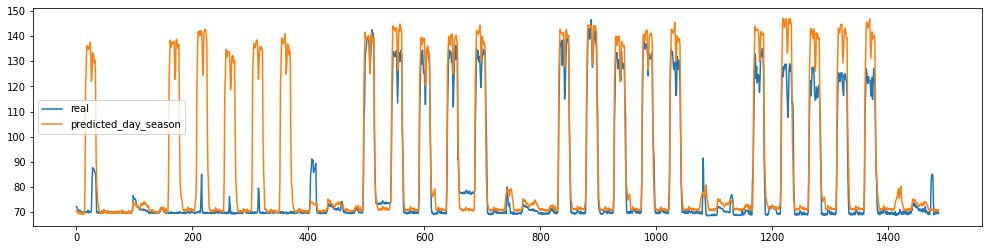

In [29]:
from scipy.optimize import minimize
class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train, alpha):
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = train.min()
        
        for t in range(self.s):
            self.theta[t] = train[t]
            self.a[t] = train[t]
        
        for t in range(self.s, self.n):
            self.a[t] = alpha[0] * (train[t] / self.theta[t - self.s]) + (1 - alpha[0]) * self.a[t - 1]
            self.theta[t] = alpha[1] * (train[t] / self.a[t]) + (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d=1):
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted
    
def optimize_alpha(alpha, s, train_data, real_data, d):
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    
    return MAE(real_data, winters_model.predict(d)) # your error function
 
result = minimize(
    lambda x: optimize_alpha(x, s_week, data[idx_start:2*idx_end].values, data[2*idx_end:idx_end:].values, d),
    x0=np.array([0.5, 0.5]),
    bounds=[(0, 1), (0, 1)]
)
alpha_optimized = result.x
winters_model = WintersNoTrend(s_week)
winters_model.fit(data.values[idx_start:idx_end], alpha_optimized)
                  
pred = winters_model.predict(d)
real_next_values = data[idx_end:].values

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": pred

    }
)


print(MRE(pred, real_next_values))
print(abs(pred.sum() - real_next_values.sum())/(real_next_values.sum()))
results_predict.plot(figsize=(17, 4))